# MAPD - B
## Management Data Part



**Author**: 
+ Andrea Nicolai (1233407)
+ Sandeep Kumar Shekhar (1236227)

#### Fun exercises Solution

We were asked to find the relation holding in the following image, thus finding at first the relationship and then computing the result.

![Assignment](img/00Fun.png)

The relationship holding is the **XOR** function (in Python denoted as "^"). Indeed:

In [2]:
print("Row one: 1 + 2 =", 1^2)
print("Row two: 2 + 5 =", 2^5)
print("Row three: 3 + 7 =", 3^7)
print("Row four: 4 + 5 =", 4^5)
print("Row five: 5 + 9 =", 5^9)

Row one: 1 + 2 = 3
Row two: 2 + 5 = 7
Row three: 3 + 7 = 4
Row four: 4 + 5 = 1
Row five: 5 + 9 = 12


# TOPIC: redundancy

We are programming a file based RAID-4 software algorithm. For this purpose we are converting a single input (**raid4.input**) file into four data files *raid4.0*, *raid4.1*, *raid4.2*, *raid4.3* and one *parity* file *raid4.4* - the four data and one parity file we call ‘stripe files’. 

In [28]:
#import the required packages to make requests and create new folders
import os
import errno
import requests
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import time
import unittest

In [36]:
#Create a folder "data" for the input file
try:
    os.makedirs("data")
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

#Download the input file and save it into the folder "data"
url = 'https://apeters.web.cern.ch/apeters/pd2021/raid4.input'
req = requests.get(url, allow_redirects=True)
input_file = "data/raid4.input"

file_size_input = open(input_file, "wb").write(req.content)
print("File has been correctly downloaded. Size in bytes is: ", file_size_input)

File has been correctly downloaded. Size in bytes is:  170619


We need now to sequentially compute, for every step, the parity of 4 bytes from the input file *raid4.input*. Every byte read is cyclically written onto files *raid4.0*, *raid4.1*, *raid4.2*, *raid4.3*, and the result of the parity operation is written onto  *raid4.4*. 

In [37]:
#Number of files needed + the one storing the parity operation
N = 4
filenames_list = ["data/raid4."+ str(i) for i in range(N + 1)]
files_list = [open(filename, "wb") for filename in filenames_list]

In [38]:
#Open the input file and read a block of N bytes
with open(input_file, "rb") as f:
    #read very first block
    single_block = f.read(N) 
    
    #do the job
    while single_block:
        BP = 0
        #padding in case of need (should happen only in the very last block)
        single_block += b'\0' * (N - len(single_block))
        #compute the parity and write sequentially into files
        for i in range(N):
            BP ^= single_block[i]
        #it has to be casted to bytes since each element of a "byte" sequence is an "int"
        for i in range(N):
            files_list[i].write(single_block[i].to_bytes(1, byteorder='big'))
        files_list[-1].write(BP.to_bytes(1, byteorder='big'))
        
        #update the "new" block and read new one
        single_block = f.read(N)

We now extend the program to compute parity of all bytes within a single stripe file, thus computing its *column-wise parity*. This quantity will work as a **checksum** for each stripe file. 

In [39]:
def column_wise_parity(filename):
    with open(filename, 'rb') as f:
        #initialization
        BP = 0
        byte = f.read(1)
        
        #do the job
        while byte != b"":
            BP ^= byte[0]
            byte = f.read(1)
            
        f.close()
    return hex(BP)

In [40]:
parity_list = []
files_list = [open(filename, "rb") for filename in filenames_list]

for i, filename in enumerate(filenames_list):
    
    parity_list.append(column_wise_parity(filename))
    print("File raid4."+str(i)+" has column-wise parity:", hex(int(parity_list[i],16)))

sizes = [os.path.getsize(filename) for filename in filenames_list]
overhead = sum(np.array(sizes)/file_size_input) - 1    
print("Total overhead is: {:.10f}%".format(100*overhead))
print("By construction all stripe files shall be of the same length:  ", sizes)

File raid4.0 has column-wise parity: 0xa5
File raid4.1 has column-wise parity: 0x7
File raid4.2 has column-wise parity: 0xa0
File raid4.3 has column-wise parity: 0x9c
File raid4.4 has column-wise parity: 0x9e
Total overhead is: 25.0007326265%
By construction all stripe files shall be of the same length:   [42655, 42655, 42655, 42655, 42655]


Here we can see that the total overhead asymptotically tends to 25%, being this valid since we might have introduced some padding zeros at the end of the strip files. In addition, the larger the input file the closer to 25% we would expect the total overhead to be. 

What is the **5-byte parity** value, if you write it it in hexadecimal format like:

$$
P^5 =0x[q_0][q_1][q_2][q_3][q_4]
$$

where the $[q_x]$ are the hexadecimal parity bytes computed by XOR-ing all bytes in each stripe file.

In [41]:
five_byte_parity = ( int(parity_list[0], 16) << 32 ) | ( int(parity_list[1], 16) << 24 )| ( int(parity_list[2], 16) << 16 ) | ( int (parity_list[3], 16) << 8) | int( parity_list[4], 16 )
print("5-bite parity is: ", hex(five_byte_parity))

5-bite parity is:  0xa507a09c9e


If you create a sixth stripe file, which contains the **row-wise parities** of the five stripe files, what would be the contents of this file?

Given the fact that the last stripe file we introduced (i.e. *raid4.4*) already contains the row-wise parities of the other files, we expect this new sixth file to contain only zeroes. Indeed, applying the parity operator to every row-parity already computed present in *raid4.4*, reduces to computing the parity operator of every value with itself, thus leading to all zeroes.

Introducing $b_i^{(j)}$ as the $i$-th byte of *raid4.j*, where $j \in \{0,1,2,3\}$, while being $p_i$ the $i$-th byte of *raid4.4*, it holds that:

$$p_i = \bigoplus_{j=0}^{3} b_i^{(j)}$$

Finally, denoting with $d_i$ the $i$-th byte of the new stripe:

$$ d_i = \left( \bigoplus_{j=0}^{3} b_i^{(j)} \right) \oplus p_i = \bigoplus_{j=0}^{3} b_i^{(j)} \oplus \bigoplus_{j=0}^{3} b_i^{(j)} = 0 \qquad \forall i$$ 

Let us show it:

In [42]:
files_list = [open(filename, "rb") for filename in filenames_list]
output_path = 'data/raid4.'+str(N+1)
output_file = open(output_path, "wb")

#Open the input file and read a block of N bytes
with open(input_file, "rb") as f:
    single_block = f.read(N) 
    
    while single_block:
        
        BP = 0
        new_BP = 0
        
        single_block += b'\0' * (N - len(single_block))
        for i in range(N):
            BP     ^= single_block[i]
            new_BP ^= single_block[i]
            
        new_BP ^= BP
        
        output_file.write(new_BP.to_bytes(1, byteorder='big'))
        single_block = f.read(N)
        
#Close the files
for file in files_list: 
    file.close()
output_file.close()

In [43]:
counter = 0
with open(output_path, "rb") as f:
    byte = f.read(1)
    while byte != b"":
        counter += byte[0]
        byte = f.read(1)

print("If what we told is correct, then counter should return zero since all elements have to zeroes -> ", counter)

If what we told is correct, then counter should return zero since all elements have to zeroes ->  0


After some time you recompute the 5-byte parity value as before. Now the result is: 

$$P^5 = 0x\ a5\ 07\ a0\ 01\ 9e$$

This means something has been corrupted. You want to reconstruct the original file *raid4.input* using the 5 stripe files.
 + Describe how you can recreate the original data file. 
 + Which stripe files do you use and how do you recreate the original data file with the correct size? 

As a first step we should compare the two 5-bytes-parities, checking in this way in which file(s) the error has occurred. 

In [44]:
print("5-bite parity previously computed is: ", hex(five_byte_parity))

5-bite parity previously computed is:  0xa507a09c9e


We are lucky that the corruption occurred only in one file, namely the fourth one (denoted by *raid4.3*), since it would be improbable that random errors have occurred in such way that other parities would remain the same. Having said so, we can retrieve the content of the corrupted file value by performing some operations with the remaining stripe files (*raid4.0*, *raid4.1*, *raid4.2*, *raid4.4* ). We will iterate over every byte and every file, after we have checked (see above) that all files have equal length. The output will finally have the same length as the file we have used to retrieve it. 

From how $b_4$ was constructed:

$$b_i^{(4)} =  b_i^{(0)} \oplus b_i^{(1)} \oplus b_i^{(2)} \oplus b_i^{(3)}$$

We can exploit XOR associativity and commutativity, and keeping in mind that $b_i^{(j)} \oplus b_i^{(j)} = 0$, in such way that we are able to compute $b_i^{(3)}$:

$$ b_i^{(2)} \oplus b_i^{(1)} \oplus b_i^{(0)}  \oplus b_i^{(4)} =  b_i^{(3)}$$

Let us prove whether the algorithm works:

In [45]:
files_list = [open(filename, "rb") for filename in filenames_list]

for byte in range(sizes[0]):
    #"corrupted" stripe file is the 4-th one, denoted by index 3
    ground_truth = files_list[3].read(1)[0]
    
    BP = 0
    BP ^= files_list[0].read(1)[0]
    BP ^= files_list[1].read(1)[0]
    BP ^= files_list[2].read(1)[0]
    BP ^= files_list[4].read(1)[0]
    
    try:
        np.testing.assert_equal(BP, ground_truth)        
    except:
        print("Reconstruction algorithm is not correct!")
        break

#Close the files
for file in files_list: 
    file.close()
if (BP == ground_truth): 
    print("Successfully reconstructed corrupted file")

Successfully reconstructed corrupted file


# TOPIC: Cryptography

The Caesar cipher is named for Julius Caesar, who used an alphabet where decrypting would shift three letters to the left. 
A friend has emailed you the following text:

**K]amua!trgpy** 

She told you that her encryption algorithm works similar to the Caesar cipher: 

+ to each ASCI value of each letter I add a secret key value. (note that ASCII values range from 0 to 255)
+ additionally to make it more secure I add a variable (so called) nonce value to each ASCII number. The nonce start value is 5 for the first character of the message. For each following character add 1 to the nonce of the previous character, e.g. for the second letter the nonce added is 6, for the third letter it is 7 and so on. 

In [47]:
message_encrypted = 'K]amua!trgpy'

Is this symmetric or asymmetric encryption and explain why?

It is a **symmetric** encryption, since both encoding and decoding occur using a unique key.

Write a small brute force program which tests keys from 0..255 and use a dictionary approach to figure out the original message. In Python you can use the ord() function to get an integer representation of a character and the chr() to retrieve a character string from an integer!

In [48]:
nonce      = np.arange(5, len(message_encrypted) + 5, dtype = int)
ASCII_text = np.array([ord(c) for c in message_encrypted])

print('Original text     : ', message_encrypted)
print('Encoded ASCII text: ', ASCII_text)

Original text     :  K]amua!trgpy
Encoded ASCII text:  [ 75  93  97 109 117  97  33 116 114 103 112 121]


In [49]:
# https://codeigo.com/python/english-dictionary
#!pip install pyenchant

From the data we were given, the **encription** should have occurred in the following way:

$$
  encrypted\_char[i]   = real\_char[i] + key + nonce[i]
$$

whereas the **decription** is simply a matter of reverting the formula, taking care to add 255 to ASCII which are below zero:

$$
    real\_char[i] = encrypted\_char[i] - key - nonce[i]
$$

In [50]:
import enchant
english_dictionary = enchant.Dict("en")
message_length = len(nonce)

#if the number is "out of bounds", then add 255 to it
def check_out_of_range(element):
    if element < 0:
        return element + 255
    else:
        return element

#get characters out of an array of ASCII numbers
def array_to_char(array):
    string = ''
    for elem in array:
        string += chr(elem)
    return string

In [82]:
#brute force approach
for key_val in range(256):
    decr_mess = ASCII_text - nonce - key_val
    decr_mess_ASCII = np.array([check_out_of_range(item) for item in decr_mess])
    decr_mess_str = array_to_char(decr_mess_ASCII)
    ###THIS "BLOCK" HAS TO BE EVENTUALLY COMMENTED SINCE LATEX WOULDN'T COMPILE BECAUSE OF UNKNOWN CHARACTERS 
    print("Decripted message is:", decr_mess_str, " #### Key is:", key_val)

Decripted message is: FWZelWheYai  #### Key is: 0
Decripted message is: EVYdkVgdX`h  #### Key is: 1
Decripted message is: DUXcjUfcW_g  #### Key is: 2
Decripted message is: CTWbiTebV^f  #### Key is: 3
Decripted message is: BSVahSdaU]e  #### Key is: 4
Decripted message is: ARU`gRc`T\d  #### Key is: 5
Decripted message is: @QT_fQb_S[c  #### Key is: 6
Decripted message is: ?PS^ePa^RZb  #### Key is: 7
Decripted message is: >OR]dO`]QYa  #### Key is: 8
_\PX`  #### Key is: 9
Decripted message is: <MP[bM^[OW_  #### Key is: 10
Decripted message is: ;LOZaL]ZNV^  #### Key is: 11
Decripted message is: :KNY`K
\YMU]  #### Key is: 12
Decripted message is: 9JMX_J	[XLT\  #### Key is: 13
Decripted message is: 8ILW^IZWKS[  #### Key is: 14
Decripted message is: 7HKV]HYVJRZ  #### Key is: 15
Decripted message is: 6GJU\GXUIQY  #### Key is: 16
Decripted message is: 5FIT[FWTHPX  #### Key is: 17
Decripted message is: 4EHSZEVSGOW  #### Key is: 18
Decripted message is: 3DGRYDURFNV  #### Key is: 19

Here one can see as the key is 245, whereas the original message was "Padova rocks". However, this approach becomes unfeasable pretty soon as the number of possible keys increases. Hence, something has to be thought and, in our case, this is represented by a **dictionary approach**.

Using a dictionary approach means to first tokenize the the string we obtain when having computed "real_char", and checking whether at least one of the words we get is present in English dictionary. Some stricter conditions, such for example that ALL (or more than 1) words must appear in an english dictionary can be implemented as well. Anyways, this avoids us to manually and visually check all "decripted" messages to check what is the actual one, thus risking to skip the correct one. Obviously, this can be done done only if we assume that our friend sends meaningful messages and in a properly spelled language...

In [55]:
suitable_decrypted_messages = []

for key_val in range(256):
    decr_mess = ASCII_text - nonce - key_val
    decr_mess_ASCII = np.array([check_out_of_range(item) for item in decr_mess])
    decr_mess_str = array_to_char(decr_mess_ASCII)
    
    decr_mess_tokenized = decr_mess_str.split()
    bool_present = False
    
    for word in decr_mess_tokenized:
        try:
            bool_present = english_dictionary.check(word)
        except:
            continue
        
    if bool_present:
        suitable_decrypted_messages.append((key_val, decr_mess_str))
        print("Possible encripted message is: ", decr_mess_str, " ###### Key is: ", key_val)
print(suitable_decrypted_messages)

Possible encripted message is:  Padova rocks  ###### Key is:  245
[(245, 'Padova rocks')]


Attempting to revert the formula to check whether we obtain the same message we received:

In [80]:
my_key    = suitable_decrypted_messages[0][0]
decr_mess = suitable_decrypted_messages[0][1]

ASCII_decr = np.array([ord(c) for c in decr_mess])
decr_mess = (ASCII_decr + nonce + my_key)%255
print("Input message was: ", message_encrypted, "\nJust encripted message is: ",  array_to_char(decr_mess))
print("Are they equal?", message_encrypted == array_to_char(decr_mess))

Input message was:  K]amua!trgpy 
Just encripted message is:  K]amua!trgpy
Are they equal? True


The **used key** is 245 , the **original message text** is "Padova rocks"

# TOPIC: Object Storage Technology 

In an object storage system we are mapping objects by name to locations
using a hash table. Imagine we have a system with ten hard disks (**10** locations). We
enumerate the location of a file using an index of the hard disk [0..9].

Our hash algorithm for placement produces hashes, which are distributed 
uniform over the value space for a flat input key distribution. 
We want now to simulate the behaviour of our hash algorithm without 
the need to actually compute any hash value. 
Instead of using real filenames, which we would hash and map using a 
hash table to a location (as we did in the exercise), we are ‘computing’ a 
location for ‘any’ file by generating a random number for the location
in the range [0..9] to assign a file location. To place a file in the storage 
system we use this random location where the file will be stored and 
consumes space.

Assume **each disk** has **1TB** of space, we have **10TB** in total.
Place as **many files** of **10GB size** as possible to hard disks choosing
random locations until one hard disk is full.
Hint: a hard disk is full once you have stored hundred 10GB files.

Write a program in Python which simulates the placement of 10GB files to random locations and account the used space on each hard disk. Once the first hard disk is full, you stop to place files

In [69]:
n_disks = 10
space_disk = 1000
filesize = 10

storage_disks = np.zeros((n_disks,), dtype = int)
tot_space_available = space_disk*n_disks

In [70]:
def simulation_files_placement(storage, space_disk, filesize):
    index = 0
    while ((storage < space_disk).all()):
        choice = np.random.randint(0, len(storage))
        storage[choice] += filesize
        index += 1
    return storage, index

def get_free_space(storage, space_disk):
    tot_space_available = space_disk*len(storage)
    free_space_perc = 100*(tot_space_available - sum(storage))/tot_space_available
    free_space = 100*(space_disk-storage)/tot_space_available
    return free_space, free_space_perc

+ How many files did you manage to place?

+ What is the percentage of total used space on all hard disks in the moment the first disk is full? 

In [71]:
storage, n_files = simulation_files_placement(storage_disks, space_disk, filesize)

print("Disks occupations [GB]: ", storage)
print("Total size occupied [GB]: ", sum(storage))
print("Total used space", 100*(1 - (tot_space_available - sum(storage))/tot_space_available), "%" )
print("Number of files placed: ", n_files)

Disks occupations [GB]:  [ 730  800  790  940  860  690  730  820  790 1000]
Total size occupied [GB]:  8150
Total used space 81.5 %
Number of files placed:  815


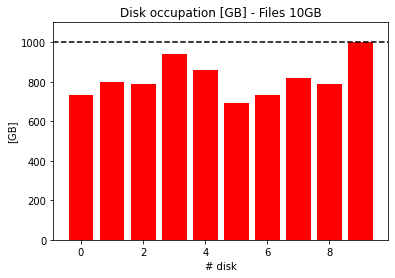

In [72]:
plt.bar(np.arange(n_disks) , storage, color = 'red')
plt.title('Disk occupation [GB] - Files 10GB')
plt.xlabel('# disk')
plt.ylabel('[GB]')
plt.ylim([0,1100])
plt.axhline(1000, color = 'black', linestyle = '--')
plt.show()

+ Repeat the same task placing 1GB files until the first hard disk is full.


In [73]:
n_disks = 10
space_disk = 1000
filesize = 1

storage_disks = np.zeros((n_disks,), dtype = int)
tot_space_available = space_disk*n_disks

In [74]:
storage, n_files = simulation_files_placement(storage_disks, space_disk, filesize)

In [75]:
print("Disks occupations [GB]: ", storage)
print("Total size occupied [GB]: ", sum(storage))
print("Total used space", 100*(1 - (tot_space_available - sum(storage))/tot_space_available), "%" )
print("Number of files placed: ", n_files)

Disks occupations [GB]:  [ 931 1000  945  957  966  948  960  906  983  935]
Total size occupied [GB]:  9531
Total used space 95.31 %
Number of files placed:  9531


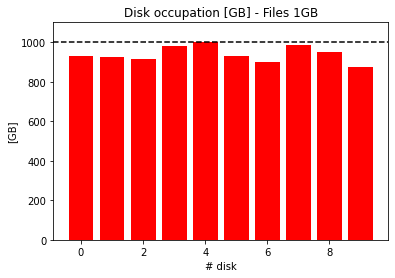

In [171]:
plt.bar(np.arange(n_disks) , storage, color = 'red')
plt.title('Disk occupation [GB] - Files 1GB')
plt.xlabel('# disk')
plt.ylabel('[GB]')
plt.ylim([0,1100])
plt.axhline(1000, color = 'black', linestyle = '--')
plt.show()

+ How many files did you manage to place?

Around 9k for 1GB files, while before one order of magnitude less, namely about 800.

+ What is the percentage of total used space on all hard disks in the moment the first disk is full? 

The percentage of total used space is 95% for files of 1GB, while 82% for larger files of 10GB. The larger the files, the less space is used.

+ Based on this observation: why do you think object storage typically stores fixed size blocks of 4M and not files of GBs size as a whole? (so called **block storage approach**). Run the same program for 4M block sizes and demonstrate the benefits

As one can easily see from the previous two histograms, when chunks are larger there will be much more free space left in the disks. Indeed for very large files (10GB) the free space is around 15%, while for smaller files (1GB) it is around 3-4%. If this pattern holds, then using block storage we expect both to put many more files and to fill more efficiently all the disks, thus avoiding large free spaces.

Let us show it:

Disks occupations [GB]:  [1000.     997.06   993.296  995.036  997.036  995.08   997.116  998.628
  999.488  996.808]
Total size occupied [GB]:  9969.54800003304
Total used space -199.68548000033041 %
Number of files placed:  2492387


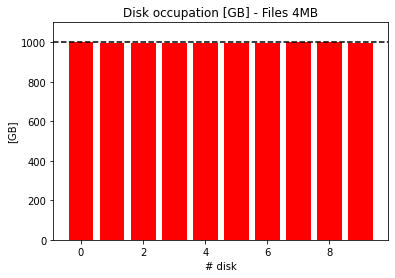

In [77]:
n_disks = 10
space_disk = 1000
filesize = 0.004

storage_disks = np.zeros((n_disks,))
tot_space_available = space_disk*n_disks

storage, n_files = simulation_files_placement(storage_disks, space_disk, filesize)

print("Disks occupations [GB]: ", storage)
print("Total size occupied [GB]: ", sum(storage))
print("Total used space", 100*((1 - tot_space_available - sum(storage))/tot_space_available), "%" )
print("Number of files placed: ", n_files)

plt.bar(np.arange(n_disks) , storage, color = 'red')
plt.title('Disk occupation [GB] - Files 4MB')
plt.xlabel('# disk')
plt.ylabel('[GB]')
plt.ylim([0,1100])
plt.axhline(1000, color = 'black', linestyle = '--')
plt.show()

Indeed we were able to put many more files (order of millions), and the total free space is much below $1\%$ ($\sim 0.2\%$). Some space however still cannot be used, but it is way less than the other case.

+ Compute the average used space on all hard disks and the standard deviation for the average used space for 10 GB and 1GB and 4M files. How is the standard deviation correlated to the block size and why?

In [234]:
file_sizes = np.geomspace(start = 0.004, stop = 100, num = 50)
statistics = np.zeros((len(file_sizes), 6))

for i, size in enumerate(file_sizes):
    n_possible_files = space_disk/size
    storage_disks = np.zeros((n_disks,))
    tot_space_available = space_disk*n_disks

    storage, n_files = simulation_files_placement(storage_disks, space_disk, size)
    free_space, free_space_perc = get_free_space(storage, space_disk)
    
    statistics[i,:] = np.array([size, n_possible_files, 
                                np.mean(free_space), np.var(free_space), 
                                np.mean(storage), np.var(storage)])


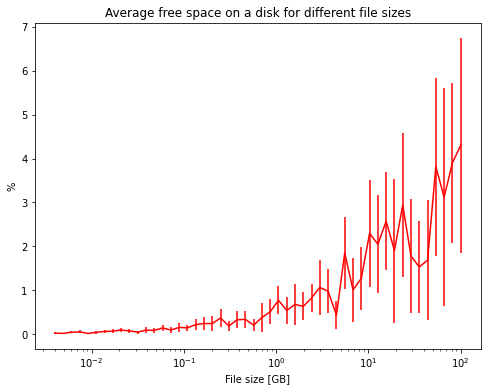

In [235]:
plt.figure(figsize= (8,6))
plt.errorbar(statistics[:,0], statistics[:,2], np.sqrt(statistics[:,3]), color = 'red')
plt.xscale('log')
plt.title('Average free space on a disk for different file sizes')
plt.ylabel('%')
plt.xlabel('File size [GB]')
plt.show()

The standard deviation scales as -0.4928745518777647


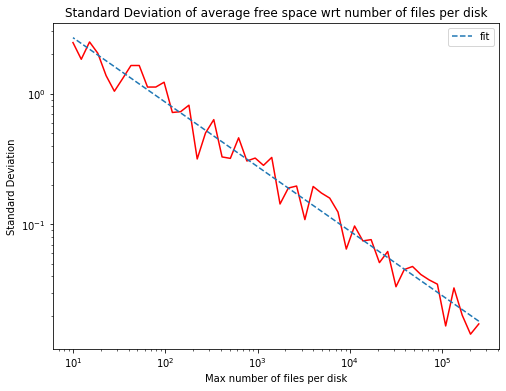

In [239]:
x = np.log(statistics[:,1])
y = np.log(np.sqrt(statistics[:,3]))
opt = np.polyfit(x, y, 1)
print("The standard deviation scales as", opt[0])

plt.figure(figsize= (8,6))
plt.plot(statistics[:,1], np.sqrt(statistics[:,3]), color = 'red')
plt.plot(statistics[:,1], np.exp(np.log(statistics[:,1])*opt[0] + opt[1]), label = 'fit', linestyle = '--')
plt.xscale('log')
plt.yscale('log')
plt.title('Standard Deviation of average free space wrt number of files per disk')
plt.ylabel('Standard Deviation')
plt.xlabel('Max number of files per disk')
plt.legend()
plt.show()

As one can see, the standard deviation of average free space scales as $1/\sqrt{N}$, where $N$ is the number of files that a single disk can contain.

Using the average space **used** obviously leads to similar results. Indeed:

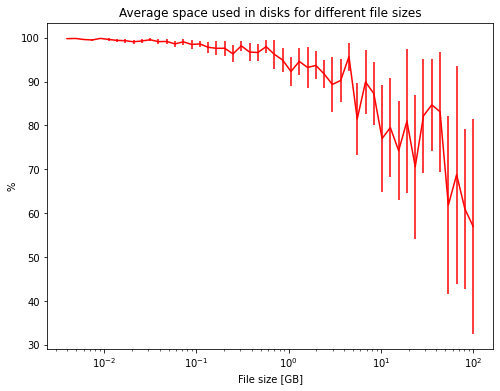

In [259]:
plt.figure(figsize= (8,6))
plt.errorbar(statistics[:,0], statistics[:,4]/n_disks, np.sqrt(statistics[:,5])/n_disks, color = 'red')
plt.xscale('log')
plt.title('Average space used in disks for different file sizes')
plt.ylabel('%')
plt.xlabel('File size [GB]')
plt.show()

The standard deviation scales as -0.4928745518777646


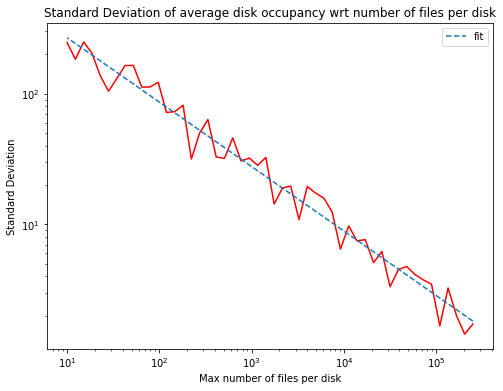

In [242]:
x = np.log(statistics[:,1])
y = np.log(np.sqrt(statistics[:,5]))
opt = np.polyfit(x, y, 1)
print("The standard deviation scales as", opt[0])

plt.figure(figsize= (8,6))
plt.plot(statistics[:,1], np.sqrt(statistics[:,5]), color = 'red')
plt.plot(statistics[:,1], np.exp(np.log(statistics[:,1])*opt[0] + opt[1]), label = 'fit', linestyle = '--')
plt.xscale('log')
plt.yscale('log')
plt.title('Standard Deviation of average disk occupancy wrt number of files per disk')
plt.ylabel('Standard Deviation')
plt.xlabel('Max number of files per disk')
plt.legend()
plt.show()

We see as the files dimension increases, conversely the number of files that can be put on a single disk decreases, as we expect when we keep the disk size fixed. Moreover, we notice as the standard deviation of the average disk occupancy decreases when the file size decreases: in other words it will not be likely that some disks will be "really full", while others being "really empty". Thus, to have all disks "more equally" filled, a block storage approach comes really handy. 

+ If we now repeat such an experiment for many more (thousands) of hard disks, which kind of distribution do you get when you do a histogram of the used space of all hard disks.

The average used/free space of all hard disk will be distributed similarly as before: with larger variance that depends on the size of the file. The larger the file size, the larger the variance. Obviously, the total number of files we store will be much more, given we considered a larger number of disks. 

Let us show it:

For files of size **0.1GB**:

Total size occupied [GB]:  967036.1000001535
Total free space 3.296389999984647 %
Number of files placed:  9670361


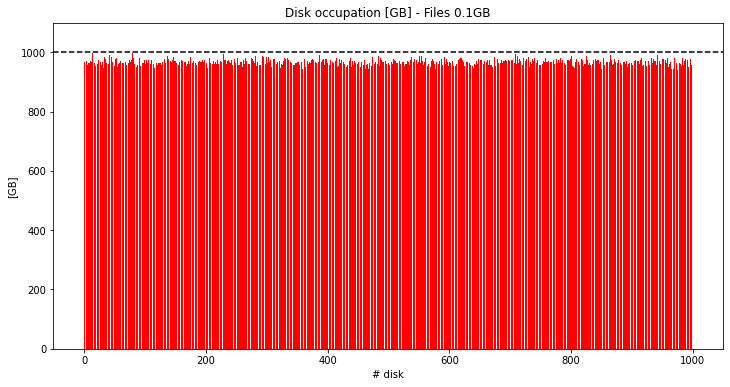

In [261]:
n_disks = 1000
storage_disks = np.zeros((n_disks,))
tot_space_available = space_disk*n_disks

storage, n_files = simulation_files_placement(storage_disks, space_disk, 0.1)

#print("Disks occupations [GB]: ", storage)
print("Total size occupied [GB]: ", sum(storage))
print("Total free space", 100*(tot_space_available - sum(storage))/tot_space_available, "%" )
print("Number of files placed: ", n_files)

plt.figure(figsize= (12,6))
plt.bar(np.arange(n_disks) , storage, color = 'red')
plt.title('Disk occupation [GB] - Files 0.1GB')
plt.xlabel('# disk')
plt.ylabel('[GB]')
plt.ylim([0,1100])
plt.axhline(1000, color = 'black', linestyle = '--')
plt.show()

For files of size **1GB**:

Total size occupied [GB]:  917398.0
Total free space 8.2602 %
Number of files placed:  917398


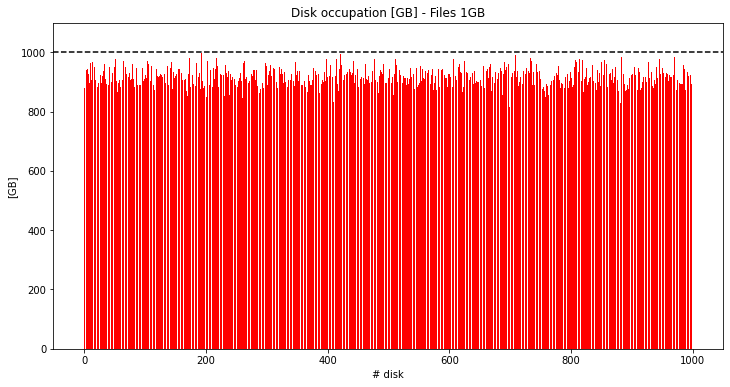

In [262]:
n_disks = 1000
storage_disks = np.zeros((n_disks,))
tot_space_available = space_disk*n_disks

storage, n_files = simulation_files_placement(storage_disks, space_disk, 1)

#print("Disks occupations [GB]: ", storage)
print("Total size occupied [GB]: ", sum(storage))
print("Total free space", 100*(tot_space_available - sum(storage))/tot_space_available, "%" )
print("Number of files placed: ", n_files)

plt.figure(figsize= (12,6))
plt.bar(np.arange(n_disks) , storage, color = 'red')
plt.title('Disk occupation [GB] - Files 1GB')
plt.xlabel('# disk')
plt.ylabel('[GB]')
plt.ylim([0,1100])
plt.axhline(1000, color = 'black', linestyle = '--')
plt.show()

For files of size **10GB**:

Total size occupied [GB]:  674120.0
Total free space 32.588 %
Number of files placed:  67412


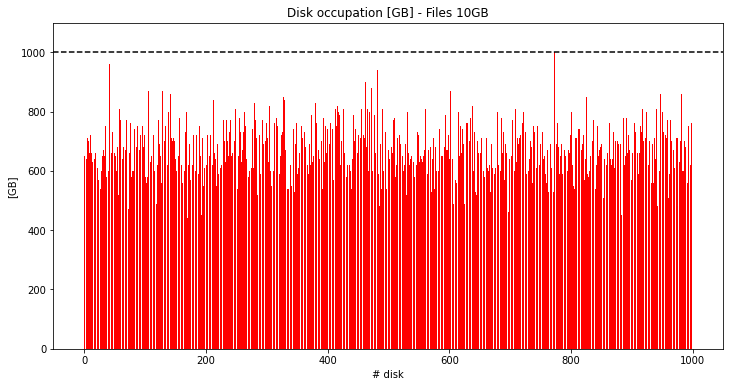

In [263]:
n_disks = 1000
storage_disks = np.zeros((n_disks,))
tot_space_available = space_disk*n_disks

storage, n_files = simulation_files_placement(storage_disks, space_disk, 10)

#print("Disks occupations [GB]: ", storage)
print("Total size occupied [GB]: ", sum(storage))
print("Total free space", 100*(tot_space_available - sum(storage))/tot_space_available, "%" )
print("Number of files placed: ", n_files)

plt.figure(figsize= (12,6))
plt.bar(np.arange(n_disks) , storage, color = 'red')
plt.title('Disk occupation [GB] - Files 10GB')
plt.xlabel('# disk')
plt.ylabel('[GB]')
plt.ylim([0,1100])
plt.axhline(1000, color = 'black', linestyle = '--')
plt.show()

Concluding: the block storage approach allows to fill more evenly the disks thus minimizing the disk loss (which is nevertheless always present!), so it is preferrable to have many small chunks rather than uploading entire files which are large (order of GB). 

# TOPIC: REST APIs and Block Chain Technology

+ Under https://pansophy.app:8443 you find a (hopefully running) Crypto Coin Server exporting a simple Block Chain. You can open this URL in any web browser to see the current Block Chain status and the account information. At the time of writing the initial birth account of the Block Chain contained 1M coins ( “genesis” : 1000000 ). The task is to implement a client and use a simple REST API to submit transactions to the Block Chain. Your goal is to book coins from other people’s accounts to your own account.


+ The server implements a **Proof Of Time** algorithm. To add a transaction tomove coins to your account, you have to submit a merit request and you have to let time pass before you can send a claim request to execute your transaction on the Block Chain. If you claim your transaction too fast after a merit request, your request is discarded. The server enforces a Proof Of Time of a minimum of 10 seconds! 

In [272]:
url = 'https://pansophy.app:8443'
response = requests.get(url, verify=False).content
jsonResponse = json.loads(response.decode('utf-8'))
jsonResponse

/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


{'accounts': {'Andreas J. Peters': 1000, 'BellaZio': 25, 'genesis': 998975},
 'chain': [{'coins': 1000000,
   'debit': 'genesis',
   'index': 0,
   'my_hash': '58f3f485104a26b61060837a2087bbb5a14ba709e380dbaed452ed9e9cb39427',
   'prev_hash': '0',
   'team': 'genesis',
   'timestamp': 1622479658.282847},
  {'coins': 1000,
   'debit': 'genesis',
   'index': 1,
   'my_hash': 'baa43458ac89290b22c8e2e3fa0689265d47e45acb8e2980227f74eab01e23ac',
   'prev_hash': '58f3f485104a26b61060837a2087bbb5a14ba709e380dbaed452ed9e9cb39427',
   'team': 'Andreas J. Peters',
   'timestamp': 1622533027.813872},
  {'coins': 25,
   'debit': 'genesis',
   'index': 2,
   'my_hash': '02f5ec3fd3e2fa557efbe2f3c809d56c7786098d13c4f1872ee90c1530c396db',
   'prev_hash': 'baa43458ac89290b22c8e2e3fa0689265d47e45acb8e2980227f74eab01e23ac',
   'team': 'BellaZio',
   'timestamp': 1622575269.245607}],
 'current_hash': '02f5ec3fd3e2fa557efbe2f3c809d56c7786098d13c4f1872ee90c1530c396db',
 'requests': {}}

Let us try to make a script that steals money from accounts that have money above a certain threshold, except our own. To do this, we implemented the following program:

In [301]:
my_account = 'BellaZio'

#get a list of accounts that have an amount of money above a certain threshold
def get_list_account_above_threshold(response, threshold = 1000, my_account = 'BellaZio'):
    parsed_list  = []
    account_list = list(jsonResponse['accounts'].keys())
    account_data = jsonResponse['accounts']
    
    for account in account_list:
        if account == my_account:
            continue
        else:
            if account_data.get(account) > threshold:
                parsed_list.append(account)
            else:
                continue
            
    return parsed_list

#create a merit body for requesting a transaction
def create_merit_json_input_data(account, money = 1000, my_account = 'BellaZio'):
    return json.dumps({
     "operation": "merit",
     "team": my_account,
     "coin": money,
     "stealfrom": account
    })

#create a body to claim the transaction
def create_claim_json(my_account = 'BellaZio'):
    return json.dumps({
     "operation": "claim",
     "team": my_account,
    })

Make a couple of transactions, just for fun:

In [331]:
import json
import requests
import random
import time
import ssl
import urllib.request

my_account = 'BellaZio'

#get a list of accounts that have an amount of money above a certain threshold
def get_list_account_above_threshold(response, threshold = 1000, my_account = 'BellaZio'):
    parsed_list  = []
    
    jsonResponse = json.loads(response.decode('utf-8'))
    account_list = list(jsonResponse['accounts'].keys())
    account_data = jsonResponse['accounts']
    
    for account in account_list:
        if account == my_account:
            continue
        else:
            if account_data.get(account) > threshold:
                parsed_list.append(account)
            else:
                continue
            
    return parsed_list

#create a merit body for requesting a transaction
def create_merit_json_input_data(account, money = 1000, my_account = 'BellaZio'):
    return json.dumps({
     "operation": "merit",
     "team": my_account,
     "coin": money,
     "stealfrom": account
    })

#create a body to claim the transaction
def create_claim_json(my_account = 'BellaZio'):
    return json.dumps({
     "operation": "claim",
     "team": my_account,
    })

my_account = 'BellaZio'

for i in range(10):
    print("Number of transactions made:", i)
    #make a get request to see the status of the chain
    response = requests.get(url, verify=False).content
    
    #get accounts whose amount of money is above a certain threshold
    list_accounts_to_steal_from = get_list_account_above_threshold(response, threshold = 1000)
    
    #draw one to take money from and compose the body
    target = random.choice(list_accounts_to_steal_from)
    merit_body = create_merit_json_input_data(target, 1000)
    
    #make the merit request and wait 10 seconds as the proof of work
    # Post Method is invoked if data != None
    req = urllib.request.Request(url, data = bytes(merit_body.encode("utf-8")), method = "POST")
    # Add the appropriate header.
    req.add_header("Content-type", "application/json; charset=UTF-8")
    with urllib.request.urlopen(req, context=ssl._create_unverified_context()) as resp:
        response_data = json.loads(resp.read().decode("utf-8"))
        if response_data.get('msg') != 'accepted':
            print("Request failed", response_data)
            break
    time.sleep(10)

    
    #make the claim request
    claim_body = create_claim_json()
    req = urllib.request.Request(url, data = bytes(claim_body.encode("utf-8")), method = "POST")
    # Add the appropriate header.
    req.add_header("Content-type", "application/json; charset=UTF-8")
    with urllib.request.urlopen(req, context=ssl._create_unverified_context()) as resp:
        response_data = json.loads(resp.read().decode("utf-8"))
        if response_data.get('msg') != 'request claimed':
            print("Request failed", response_data)
            break

Number of transactions made: 0


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 1


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 2


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 3


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 4


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 5


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 6


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 7


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 8


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Number of transactions made: 9


/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [332]:
response = requests.get(url, verify=False).content
jsonResponse = json.loads(response.decode('utf-8'))
jsonResponse

/home/andrea/.local/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


{'accounts': {'Andreas J. Peters': 1000,
  'BellaZio': 19025,
  'bellaZio': 1000,
  'genesis': 978975},
 'chain': [{'coins': 1000000,
   'debit': 'genesis',
   'index': 0,
   'my_hash': '58f3f485104a26b61060837a2087bbb5a14ba709e380dbaed452ed9e9cb39427',
   'prev_hash': '0',
   'team': 'genesis',
   'timestamp': 1622479658.282847},
  {'coins': 1000,
   'debit': 'genesis',
   'index': 1,
   'my_hash': 'baa43458ac89290b22c8e2e3fa0689265d47e45acb8e2980227f74eab01e23ac',
   'prev_hash': '58f3f485104a26b61060837a2087bbb5a14ba709e380dbaed452ed9e9cb39427',
   'team': 'Andreas J. Peters',
   'timestamp': 1622533027.813872},
  {'coins': 25,
   'debit': 'genesis',
   'index': 2,
   'my_hash': '02f5ec3fd3e2fa557efbe2f3c809d56c7786098d13c4f1872ee90c1530c396db',
   'prev_hash': 'baa43458ac89290b22c8e2e3fa0689265d47e45acb8e2980227f74eab01e23ac',
   'team': 'BellaZio',
   'timestamp': 1622575269.245607},
  {'coins': 1000,
   'debit': 'genesis',
   'index': 3,
   'my_hash': '667aa39a20df64bb68397b54f30

+ What is the maximum number of transactions one given team can add to the Block Chain in one day?

In [310]:
n_sec_day = 60*60*24
proof_of_time = 10

max_transactions = n_sec_day/proof_of_time

print("The maximum number of transactions that a team can make, assuming no latency, is:", int(max_transactions))

The maximum number of transactions that a team can make, assuming no latency, is: 8640


`def calculate_hash(self):
    block_of_string = “{}{}{}{}{}”.format( self.index,
                                       self.team,
                                       self.prev_hash, 
                                       self.coins, 
                                       self.timestamp)
    self.my_hash = hashlib.sha256(block_of_string.encode()).hexdigest()
    return self.my_hash
`

 + Explain what this function does and why is this ‘the key’ for Block Chain technology? 

This function takes as input a blockchain, and is called when a claim request is made. It therefore calculates a hash based on the index of the transaction one wants to validate, the team that requested it, the previous hash (this is the reason why it is a "chain", since it clearly depends on previous blocks), the amount of coins requested and finally the time when this request was made. A block essentially store all this information, which is described in the input parameters of `calculate_hash function`, and can be flattened to a concatenated string from which one computes the hash.

+ If you have the knowledge of the hash function, how can you validate the contents of the Block Chain you received using a GET request to make sure, nobody has tampered with it? You don’t need to implement it! Explain the algorithm to validate a Block Chain! 

If even a single bit of input data is changed or does not correspond to actual data the hash abruptly changes, meaning that the contents of the blockchain have been changed by someone. If we know how the hash is computed and the very first hash, we can easily make a GET request and sequentially compute hashes and check whether they coincide. If they do, the chain content is valid, otherwise someone has tampered it. 

+ Why might the GET REST API run into scalability problems? Express the scalability behaviour of execution times of GET and POST requests in **Big O** notation in relation to the number of transactions recorded in the Block Chain! Draw execution time vs transactions for GET and POST requests. 

Blockchains usually save transactions which are validated, and their data, in a hash table. Since GET method is a way to look up for an already existing resource in an hash table, it looks like a "search operation" which we know to have time complexity, on average, equal to $\mathcal{O}(1+n/k)$, where $n/k$ is the so called *load factor* proportional to the number of entries $n$, hence this might lead to scalability issues for large $n$.

1. GET transactions have time complexity, on average, $\mathcal{O}(1+n/k)$. In worst cases, however: $\mathcal{O}(n)$, namely when we have only a single bucket $(k=1)$.
2. POST transactions, instead, are equall to add some entries to the hash table and ideally this is independent on the number of entries (unless some sort of indexing is present). Therefore $\mathcal{O}(1)$.

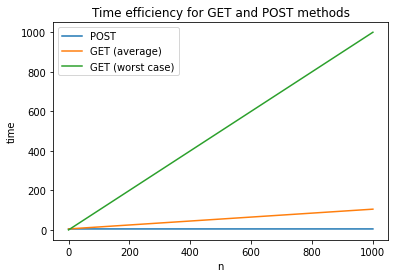

In [78]:
#here we assume k to be "10", namely a total of 10 buckets (or chunks/indexes)
n = np.arange(0.01, 1000, step = 0.01)
const = np.array([5 for i in n])
search_av = np.array([5 + i/10 for i in n ])

plt.plot(n, const, label = "POST")
plt.plot(n, search_av, label = "GET (average)")
plt.plot(n, n, label = "GET (worst case)")
plt.xlabel("n")
plt.ylabel("time")
plt.legend()
plt.title("Time efficiency for GET and POST methods")
plt.show()

+ If the Crypto server goes down, the way it is implemented it loses the current account balances. How can the server recompute the account balances after a restart from the saved Block Chain?

If we have knowledge of the starting conditions of the Block Chain (namely account balances and starting hash at time 0), one can easily reconstruct and validate all the others blocks of the chain by computing hashes using the necessary information (team that requested transactions, from whom, how much etc...), thus finding matching hashes in the block chain and being able to successfully reconstruct it in a sequential and chronologically ordered way (exploiting timestamps as well). In this way, one should be able to find current users' balances.

+ What are the advantages of using a REST API and JSON in a client-server architecture? What are possible disadvantages?

A REST/RESTful API is useful since it is horizontally scalable, given that the server does not store user's session: it simply returns its state according to the requests made (indeed resources can be modified by DELETE, PATCH, POST etc...). Users' sessions are handled directly by the clients themselves, but in case of too much traffic a network-load balancer can be exploited. Communication between client and server occurs using easy-to-manage formats, such as JSON or XML, specially for back-ends application which many times are written in NodeJS, Python (Flask), or other versatile languages for this purpose.
The price to pay might be a bandwith cost involved in the communication server-user which sometimes might appear redundant: we are indeed forced to send again the same information every time we make any request, thus sending many times the same information, for example in the case of a *session token*. However one should notice that this really helps the server in not storing every user's information thus occupying less memory, and costs therefore are somehow negligible compared to advantages.